In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split


In [495]:
TICKER = 'NVDA'

In [528]:
# Load the CSV file
data = pd.read_csv('../data/year_delta.csv')

# Change all empty of inf values to 0.0
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0.0)

 # Filter by symbol
data = data[data['act_symbol'] == TICKER]

# Separate features (X) and target (y)
features = data.drop(columns=['adjusted_price', 'date', 'act_symbol'])
target = data['adjusted_price']

# Retain the last row before excluding it for training
last_row = features.iloc[-1:]

# Exclude the last row for training
features = features[:-1]

# Drop problematic columns entirely for consistency
features = features.dropna(axis=1)

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_X.fit_transform(features)
scaled_target = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Preprocess the last row
scaled_last_row = scaler_X.transform(last_row)


In [541]:
def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 5
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=False)

In [550]:
# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [551]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - loss: 0.3170 - val_loss: 0.0969
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0100 - val_loss: 0.4178
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0861 - val_loss: 0.5429
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1446 - val_loss: 0.4011
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0901 - val_loss: 0.2211
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0248 - val_loss: 0.1155
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.0908
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0172 - val_loss: 0.1035
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0424 - val_loss: 0.1136
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0536 - val_loss: 0.1084
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0457 - val_loss: 0.0968
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0271 - val_loss: 0.0928


In [555]:
# Prepare the last sequence for prediction
# Use the last `time_steps` rows from the scaled_features plus the scaled_last_row
last_sequence = np.vstack([scaled_features[-(time_steps - 1):], scaled_last_row])
last_sequence = last_sequence.reshape(1, time_steps, -1)  # Reshape for LSTM input

# Make the prediction
predicted_scaled_price = model.predict(last_sequence)

# Inverse transform the scaled prediction to get the actual price
predicted_price = scaler_y.inverse_transform(predicted_scaled_price)
print("Predicted price for the last row:", predicted_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted price for the last row: 1.9026408


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


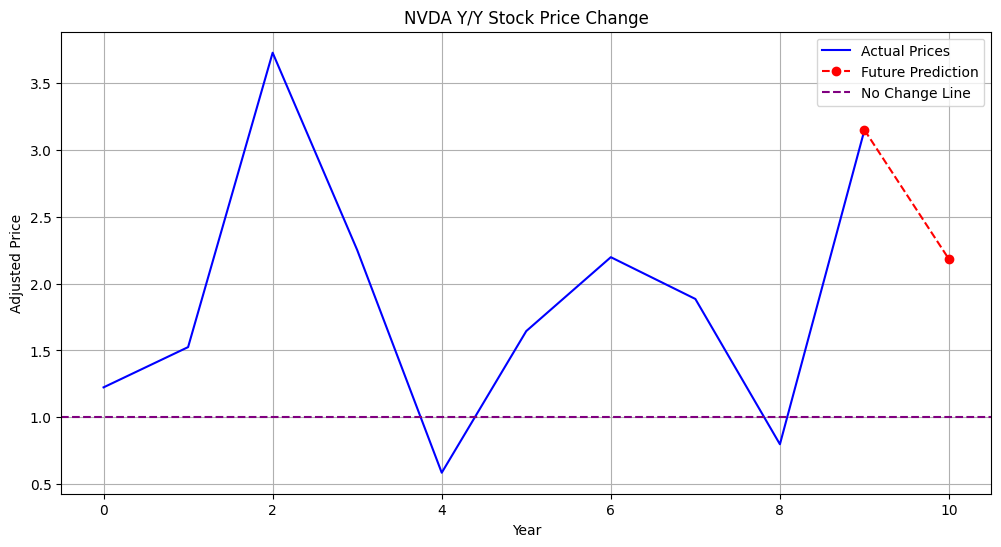

Predicted Price Change for the Next Year: 2.18


In [556]:
import matplotlib.pyplot as plt

# Predict the next quarter
latest_sequence = scaled_features[-time_steps:].reshape(1, time_steps, scaled_features.shape[1])
predicted_scaled_future = model.predict(latest_sequence)
predicted_future_price = scaler_y.inverse_transform(predicted_scaled_future)

# Prepare historical data
historical_prices = scaler_y.inverse_transform(scaled_target).flatten()
timeline = list(range(len(historical_prices)))

# Extend timeline and prices for future prediction
extended_timeline = timeline + [timeline[-1] + 1]
extended_prices = list(historical_prices) + [predicted_future_price[0][0]]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(timeline[0: -1], historical_prices[0: -1], label="Actual Prices", color="blue", linestyle="-")

plt.plot([timeline[-2], extended_timeline[-2]], [historical_prices[-2], predicted_future_price[0][0]], 
         label="Future Prediction", color="red", linestyle="--", marker='o')

# Add a horizontal line at y = 1
plt.axhline(y=1, color='purple', linestyle='--', label="No Change Line")

plt.title(f"{TICKER} Y/Y Stock Price Change")
plt.xlabel("Year")
plt.ylabel("Adjusted Price")
plt.legend(loc="best")
plt.grid()
plt.show()

print(f"Predicted Price Change for the Next Year: {predicted_future_price[0][0]:.2f}")


In [527]:
# Debugging outputs to ensure correctness
print("Original Data Shape:", data.shape)
print("Scaled Features Shape:", scaled_features.shape)
print("Scaled Target Shape:", scaled_target.shape)

# Check for NaN in scaled data
print("NaN in Scaled Features:", np.isnan(scaled_features).sum())
print("NaN in Scaled Target:", np.isnan(scaled_target).sum())

# Inspect the first feature-target pair after sequence creation
print("First Sequence (X):", X[0])
print("First Target (y):", y[0])

# Ensure model is compiled correctly
print("Model Summary:")
model.summary()

# Check prediction shape
print("Latest Sequence Shape:", latest_sequence.shape)


Original Data Shape: (11, 135)
Scaled Features Shape: (10, 132)
Scaled Target Shape: (11, 1)
NaN in Scaled Features: 0
NaN in Scaled Target: 0
First Sequence (X): [[0.5186587  0.10566222 0.         0.22241275 0.07128821 0.37945395
  0.16297821 0.         0.         0.         0.00955646 0.05345982
  0.27211151 0.         0.14285714 0.05615117 0.55817492 0.05510753
  1.         0.1241338  0.27211151 0.         0.63901783 0.
  0.22335189 0.         0.         0.25693363 0.         0.
  0.16392264 0.         0.         0.         0.         1.
  0.12008841 0.         0.59783168 0.14753853 0.08444539 0.45293738
  0.         0.18752872 0.26707544 0.26708756 0.         0.82673989
  0.55746167 0.82668033 1.         0.         0.         1.
  0.0713492  0.         0.         0.64127894 0.07357608 0.1078092
  0.20878331 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.04847247 0.         0.17467954 0.19626098 0.15899521
  

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_62 (LSTM)                  │ (None, 128)            │       133,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,285 (1.53 MB)

 Trainable params: 133,761 (522.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 267,524 (1.02 MB)

Latest Sequence Shape: (1, 5, 132)
